In [82]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
from skimage.feature import hog
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

In [83]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier("PreTrainedCascade/haarcascade_frontalface_default.xml")

In [84]:
# Function to Load images, detect faces, and extract cropped face regions
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        images. append(face_region)
                        labels.append(label)
    return images, labels

In [85]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img = cv2.resize(img, (64, 64)) # Resize to standard size
        # Compute HOG features
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feat)
    return np.array(hog_features)

In [86]:
# Data Augmentation
def augment_data(images, labels):
    augmented_images, augmented_labels = [], []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)
        # Augmentations: Flip, Higher Brightness
        flipped_image = cv2.flip(img, 1) # Horizontal flip
        brighter_image = cv2.convertScaleAbs(flipped_image, alpha=1.2, beta=20) # Brightness adjustment
        augmented_images.append(brighter_image)
        augmented_labels.append(label)
    return augmented_images, augmented_labels

In [87]:
def data_preprocessing(folder_path):
    
    # Set paths for training and testing folders
    train_folder_path = folder_path + "/train"
    test_folder_path = folder_path + "/test"

    # Load and detect faces for training
    train_photos, train_labels = load_and_detect_faces(train_folder_path)

    # Count and display the number of images in each label
    label_counts = Counter(train_labels)
    print("Label distribution before any data augmentation for training:", label_counts)

    # Data augmentation with image flipping horizontally
    train_photos, train_labels = augment_data(train_photos, train_labels)

    # Extract features for training data
    train_photos_with_features = extract_hog_features(train_photos)

    # Count and display the number of images in each label
    label_counts = Counter(train_labels)
    print("Label distribution after horizontal flipping but before SMOTE:", label_counts)

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=40)
    train_photos_with_features, train_labels = smote.fit_resample(train_photos_with_features, train_labels)

    # Verify the label distribution after applying SMOTE
    label_counts = Counter(train_labels)
    print("Label distribution after SMOTE:", label_counts)

    # Load and detect faces for testing
    test_photos, test_labels = load_and_detect_faces(test_folder_path)

    # Count and display the number of images in each label
    label_counts = Counter(test_labels)
    print("Label distribution before any data augmentation for testing:", label_counts)

    # Data augmentation with image flipping horizontally
    test_photos, test_labels = augment_data(test_photos, test_labels)

    # Count and display the number of images in each label
    label_counts = Counter(test_labels)
    print("Label distribution after horizontal flipping but before SMOTE:", label_counts)

    # Extract features for testing data
    test_photos_with_features = extract_hog_features(test_photos)

    # Apply SMOTE to balance the dataset
    test_photos_with_features, test_labels = smote.fit_resample(test_photos_with_features, test_labels)

    # Verify the label distribution after applying SMOTE
    label_counts = Counter(test_labels)
    print("Label distribution after SMOTE:", label_counts)

    return train_photos_with_features, train_labels, test_photos_with_features, test_labels

In [88]:
def calculate_accuracies(test_labels, predicted_labels):
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    # Calculate precision, recal and F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
    report = classification_report(test_labels, predicted_labels)

    # Print overall test metrics
    print(f"\nTest Accuracy:  {accuracy * 100:.2f}%")
    print(f"Test Precision: {precision * 100:.2f}%")
    print(f"Test Recall:    {recall * 100:.2f}%")
    print(f"Test F1-Score:  {f1:.2f}")
    print("\nClassification Report:\n", report)

In [89]:
def show_predictions_from_folder(images, predictions, filenames, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(min(n, len(images))):
        img = images[i]
        pred_label = predictions[i]
        filename = filenames[i]
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(f'Original: {filename}\nPrediction: {pred_label}')
        plt.axis('off')
    plt.show()

In [90]:
def data_preprocessing_for_testing(folder_path = "testimages"):

    # Load and detect faces for testing
    test_photos, test_labels = load_and_detect_faces(folder_path)

    # Extract features for testing data
    test_photos_with_features = extract_hog_features(test_photos)

    return test_photos_with_features, test_labels, test_photos

In [91]:
def train_predict_and_calc_acc(classifier: SVC, train_photos_with_features, train_labels, test_photos_with_features, test_labels, test_folder_path="testimages"):

    # Cross-validation setup
    print("\nPerforming cross-validation:")
    
    # Combine features and labels
    combined_features = np.vstack((train_photos_with_features, test_photos_with_features))
    combined_labels = np.hstack((train_labels, test_labels))
    
    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(
        classifier,
        combined_features,
        combined_labels,
        cv=skf,
        scoring='accuracy'
    )
    print(f"Cross-validation accuracy scores: {cross_val_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cross_val_scores) * 100:.2f}%")

    # Train the classifier on the training data
    classifier.fit(train_photos_with_features, train_labels)

    # Predict on the test set
    predicted_labels = classifier.predict(test_photos_with_features)
    
    # Display accuracy
    calculate_accuracies(test_labels, predicted_labels)

    # Display Confusion Matrix
    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Assuming class names are defined
    class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
    
    # Calculate percentages
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

    # Plot confusion matrix with class names
    plt. figure(figsize=(8, 8))
    ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

    # Add annotations with both counts and percentages
    for i in range(conf_matrix.shape[0]):
        for j in range (conf_matrix.shape[1]):
            count = conf_matrix[i, j]
            ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt. title("Confusion Matrix")
    plt. show()


    test_photos_with_features, test_labels, test_photos = data_preprocessing_for_testing()
    test_predictions = classifier.predict(test_photos_with_features)
    show_predictions_from_folder(test_photos, test_predictions, test_labels)


In [92]:
# Create SVM classifiers with different kernels, calculate training and testing loss, and plot the loss vs. kernels
def plot_svm_loss_vs_kernels(train_data, train_labels, test_data, test_labels, kernels, dataset_name="Dataset"):

    train_losses = []
    test_losses = []

    for kernel in kernels:
        # Create an SVM classifier with the current kernel
        classifier = SVC(kernel=kernel, probability=True)
        classifier.fit(train_data, train_labels)

        # Calculate training loss
        train_pred_proba = classifier.predict_proba(train_data)
        train_loss = log_loss(train_labels, train_pred_proba)
        train_losses.append(train_loss)

        # Calculate testing loss
        test_pred_proba = classifier.predict_proba(test_data)
        test_loss = log_loss(test_labels, test_pred_proba)
        test_losses.append(test_loss)

        print(f"Kernel: {kernel} | Training Loss: {train_loss:.4f} | Testing Loss: {test_loss:.4f}")

    # Plot the training and testing losses
    plt.figure(figsize=(10, 6))
    plt.plot(kernels, train_losses, label="Training Loss", marker='o')
    plt.plot(kernels, test_losses, label="Testing Loss", marker='o')
    plt.xlabel("Kernel")
    plt.ylabel("Loss")
    plt.title(f"SVM Loss vs. Kernals with {dataset_name} Dataset")
    plt.legend(["Training Loss", "Testing Loss"])
    plt.grid(True)
    plt.show()

In [93]:
# Create SVM classifiers with increasing gamma values, calculate training and testing loss, and plot the loss vs gamma values
def plot_svm_loss_vs_gamma(train_data, train_labels, test_data, test_labels, gamma_values, dataset_name="Dataset"):
    
    train_losses = []
    test_losses = []

    for gamma in gamma_values:
        # Create an SVM classifier with the current gamma value
        classifier = SVC(kernel='rbf', gamma=gamma, probability=True)
        classifier.fit(train_data, train_labels)

        # Calculate training loss
        train_pred_proba = classifier.predict_proba(train_data)
        train_loss = log_loss(train_labels, train_pred_proba)
        train_losses.append(train_loss)

        # Calculate testing loss
        test_pred_proba = classifier.predict_proba(test_data)
        test_loss = log_loss(test_labels, test_pred_proba)
        test_losses.append(test_loss)

        print(f"Gamma: {gamma} | Training Loss: {train_loss:.4f} | Testing Loss: {test_loss:.4f}")

    # Plot the training and testing losses
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_values, train_losses, label="Training Loss", marker='o')
    plt.plot(gamma_values, test_losses, label="Testing Loss", marker='o')
    plt.xscale('log')  # Gamma values often vary logarithmically
    plt.xlabel("Gamma")
    plt.ylabel("Loss")
    plt.title(f"SVM Loss vs. Gamma with {dataset_name} Dataset")
    plt.legend()
    plt.grid(True)
    plt.show()

In [94]:
# Initialize the dataset folderpath
CK_dataset = "CK_dataset"
JAFFE_dataset = "JAFFE-[70,30]"

print("JAFFE Dataset:")
JAFFE = []
JAFFE.extend(data_preprocessing(JAFFE_dataset))

print("\nCK Dataset:")
CK = []
CK.extend(data_preprocessing(CK_dataset))

JAFFE Dataset:
Label distribution before any data augmentation for training: Counter({'Happy': 22, 'Sad': 22, 'Fear': 22, 'Surprise': 21, 'Neutral': 21, 'Angry': 20})
Label distribution after horizontal flipping but before SMOTE: Counter({'Happy': 44, 'Sad': 44, 'Fear': 44, 'Surprise': 42, 'Neutral': 42, 'Angry': 40})
Label distribution after SMOTE: Counter({'Happy': 44, 'Sad': 44, 'Fear': 44, 'Surprise': 44, 'Neutral': 44, 'Angry': 44})
Label distribution before any data augmentation for testing: Counter({'Fear': 10, 'Happy': 9, 'Sad': 9, 'Surprise': 9, 'Neutral': 9, 'Angry': 9})
Label distribution after horizontal flipping but before SMOTE: Counter({'Fear': 20, 'Happy': 18, 'Sad': 18, 'Surprise': 18, 'Neutral': 18, 'Angry': 18})
Label distribution after SMOTE: Counter({'Happy': 20, 'Sad': 20, 'Fear': 20, 'Surprise': 20, 'Neutral': 20, 'Angry': 20})

CK Dataset:
Label distribution before any data augmentation for training: Counter({'neutral': 86, 'surprise': 82, 'happy': 75, 'sadness'

Kernel: linear | Training Loss: 0.0269 | Testing Loss: 0.5833
Kernel: rbf | Training Loss: 0.1337 | Testing Loss: 0.6494
Kernel: poly | Training Loss: 0.0205 | Testing Loss: 0.5592
Kernel: sigmoid | Training Loss: 1.8013 | Testing Loss: 1.8015


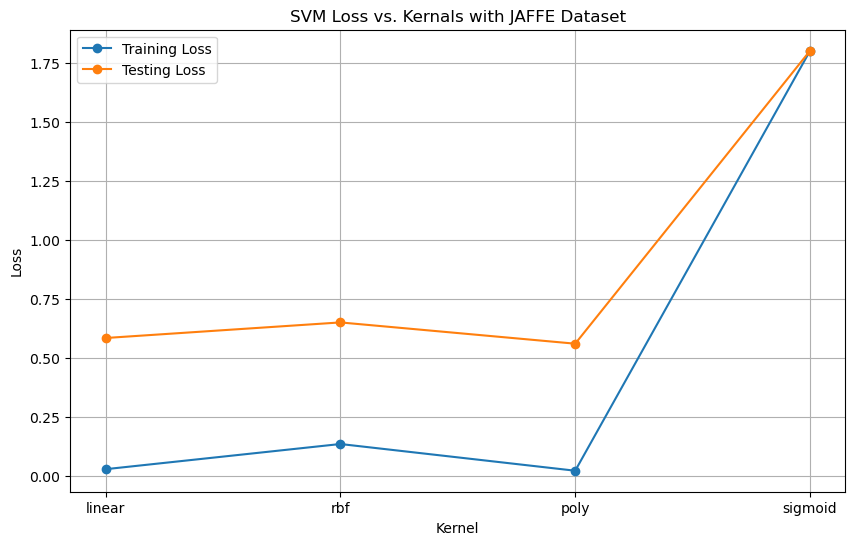

Kernel: linear | Training Loss: 0.1115 | Testing Loss: 1.9388
Kernel: rbf | Training Loss: 0.1770 | Testing Loss: 1.5189
Kernel: poly | Training Loss: 0.0807 | Testing Loss: 1.9314
Kernel: sigmoid | Training Loss: 0.9036 | Testing Loss: 1.1272


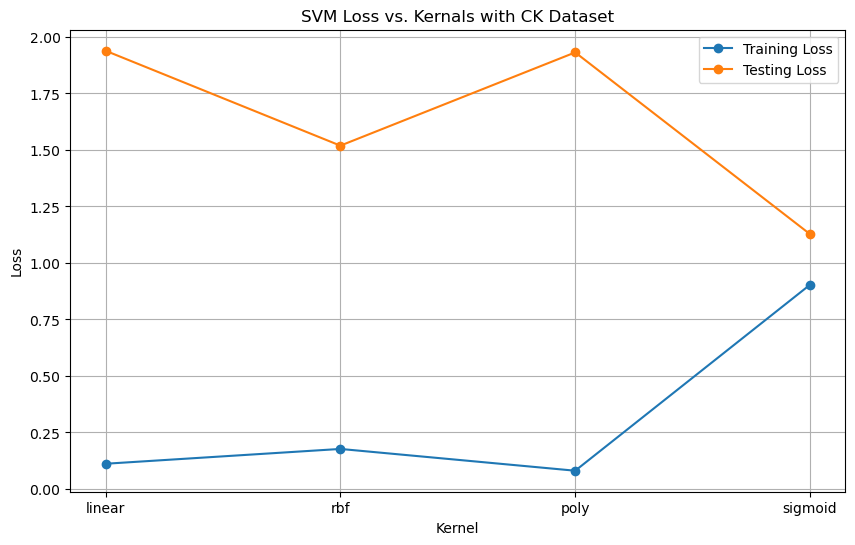

In [95]:
# Define kernel types to compare
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

plot_svm_loss_vs_kernels(*JAFFE, kernels, "JAFFE")
plot_svm_loss_vs_kernels(*CK, kernels, "CK")

Gamma: 0.001 | Training Loss: 1.7650 | Testing Loss: 1.7696
Gamma: 0.01 | Training Loss: 1.0188 | Testing Loss: 1.1178
Gamma: 0.1 | Training Loss: 0.0377 | Testing Loss: 0.6910
Gamma: 1 | Training Loss: 2.2923 | Testing Loss: 1.7920
Gamma: 10 | Training Loss: 5.8370 | Testing Loss: 1.7919
Gamma: 100 | Training Loss: 5.6343 | Testing Loss: 1.7918


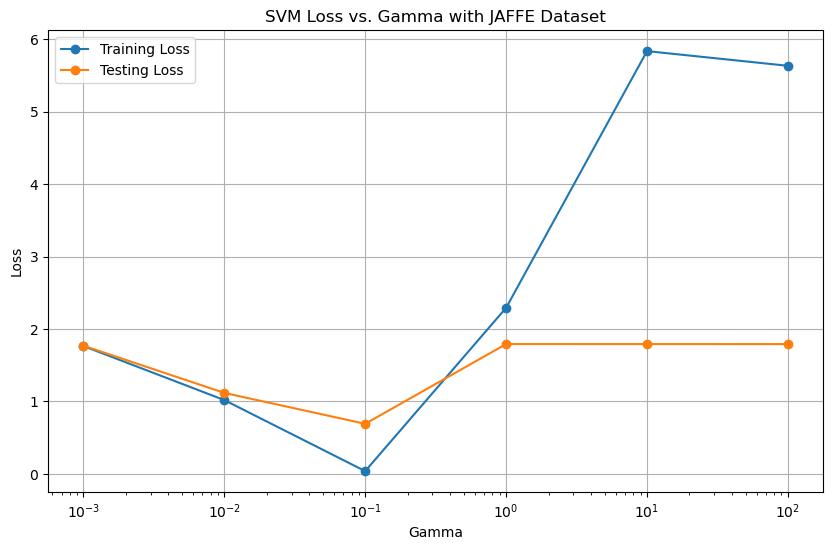

Gamma: 0.001 | Training Loss: 1.3443 | Testing Loss: 1.4051
Gamma: 0.01 | Training Loss: 0.4967 | Testing Loss: 1.2439
Gamma: 0.1 | Training Loss: 0.0740 | Testing Loss: 1.5824
Gamma: 1 | Training Loss: 0.1014 | Testing Loss: 2.2533
Gamma: 10 | Training Loss: 1.0165 | Testing Loss: 1.8172
Gamma: 100 | Training Loss: 1.6115 | Testing Loss: 1.7932


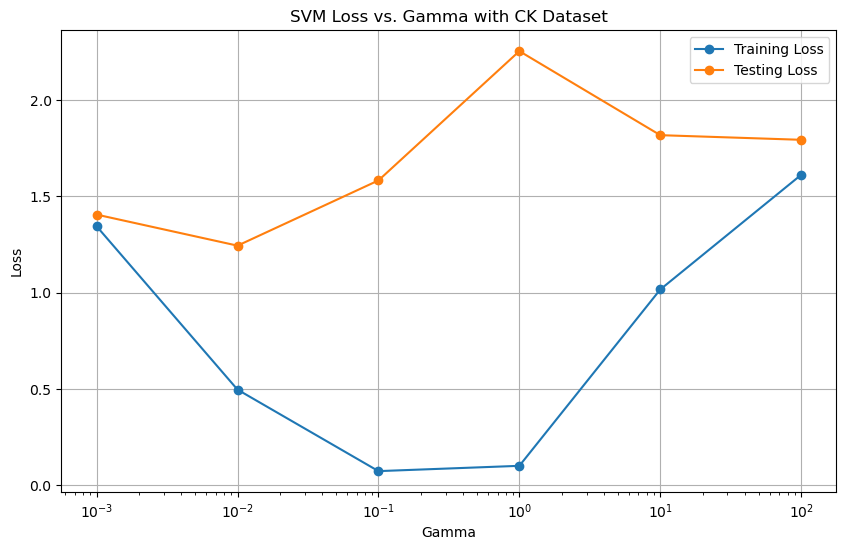

In [96]:
# Finding optimum gamma value for the classifier
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100]

plot_svm_loss_vs_gamma(*JAFFE, gamma_values, "JAFFE")
plot_svm_loss_vs_gamma(*CK, gamma_values, "CK")

Gamma: 0.1 | Training Loss: 0.0416 | Testing Loss: 0.6662
Gamma: 0.2 | Training Loss: 0.0046 | Testing Loss: 0.8898
Gamma: 0.3 | Training Loss: 0.0095 | Testing Loss: 1.3258
Gamma: 0.4 | Training Loss: 0.0018 | Testing Loss: 1.6175
Gamma: 0.5 | Training Loss: 0.0807 | Testing Loss: 1.7676
Gamma: 0.6 | Training Loss: 0.0311 | Testing Loss: 1.7872
Gamma: 0.7 | Training Loss: 2.0987 | Testing Loss: 1.7920
Gamma: 0.8 | Training Loss: 1.7199 | Testing Loss: 1.7920
Gamma: 0.9 | Training Loss: 1.3716 | Testing Loss: 1.7921
Gamma: 1 | Training Loss: 1.7960 | Testing Loss: 1.7919


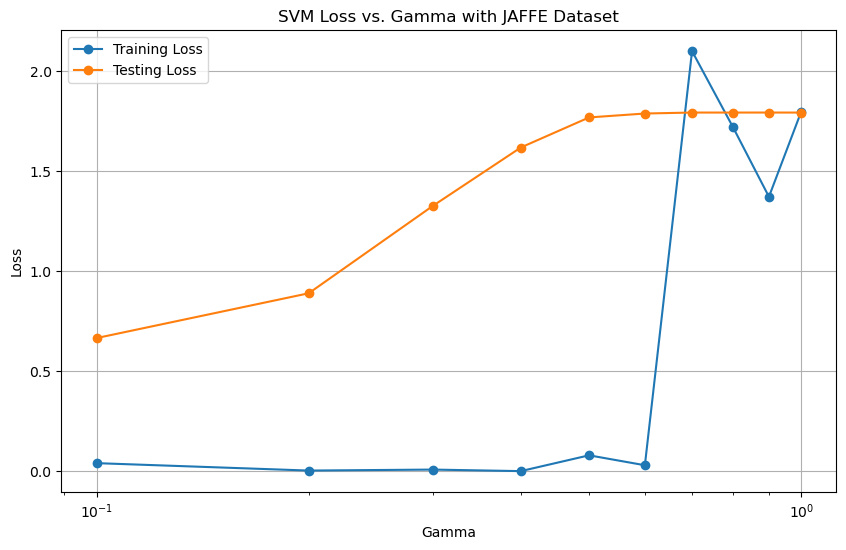

Gamma: 0.1 | Training Loss: 0.0801 | Testing Loss: 1.6667
Gamma: 0.2 | Training Loss: 0.0122 | Testing Loss: 1.8145
Gamma: 0.3 | Training Loss: 0.0026 | Testing Loss: 1.8429
Gamma: 0.4 | Training Loss: 0.0041 | Testing Loss: 2.0291
Gamma: 0.5 | Training Loss: 0.0001 | Testing Loss: 2.2383
Gamma: 0.6 | Training Loss: 0.0052 | Testing Loss: 2.2419
Gamma: 0.7 | Training Loss: 0.0001 | Testing Loss: 2.2675
Gamma: 0.8 | Training Loss: 0.0046 | Testing Loss: 2.4277
Gamma: 0.9 | Training Loss: 0.0026 | Testing Loss: 2.3445
Gamma: 1 | Training Loss: 0.0231 | Testing Loss: 2.3105


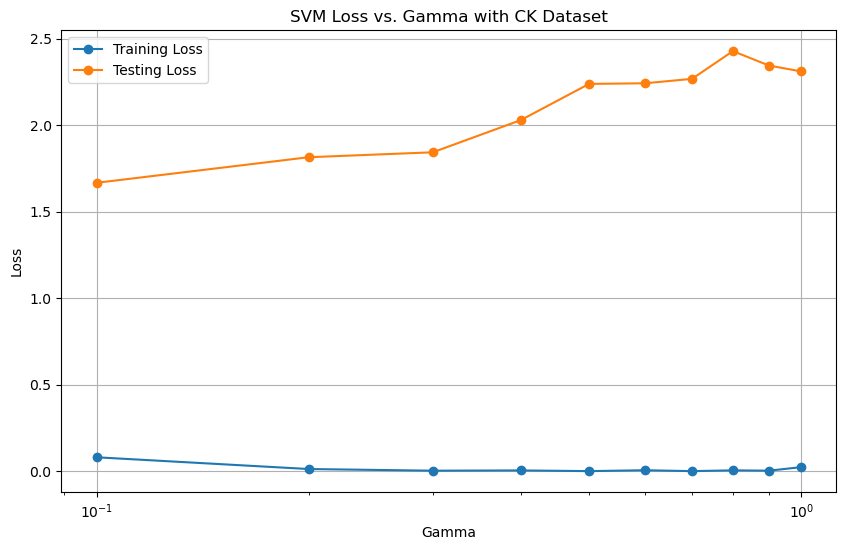

In [97]:
# Finding optimum gamma value for the classifier
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plot_svm_loss_vs_gamma(*JAFFE, gamma_values, "JAFFE")
plot_svm_loss_vs_gamma(*CK, gamma_values, "CK")

In [98]:
# Initialize the Support Vector Classifier
svm_classifier = SVC(kernel='rbf', gamma=0.1, probability=True, class_weight='balanced')


Performing cross-validation:
Cross-validation accuracy scores: [0.90909091 0.85714286 0.92207792 0.90909091 0.90789474]
Mean cross-validation accuracy: 90.11%

Test Accuracy:  84.17%
Test Precision: 88.29%
Test Recall:    84.17%
Test F1-Score:  0.84

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.70      0.82        20
        Fear       0.78      0.90      0.84        20
       Happy       1.00      0.70      0.82        20
     Neutral       0.87      1.00      0.93        20
         Sad       0.65      1.00      0.78        20
    Surprise       1.00      0.75      0.86        20

    accuracy                           0.84       120
   macro avg       0.88      0.84      0.84       120
weighted avg       0.88      0.84      0.84       120


Confusion Matrix:
[[14  0  0  0  6  0]
 [ 0 18  0  0  2  0]
 [ 0  0 14  3  3  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 20  0]
 [ 0  5  0  0  0 15]]


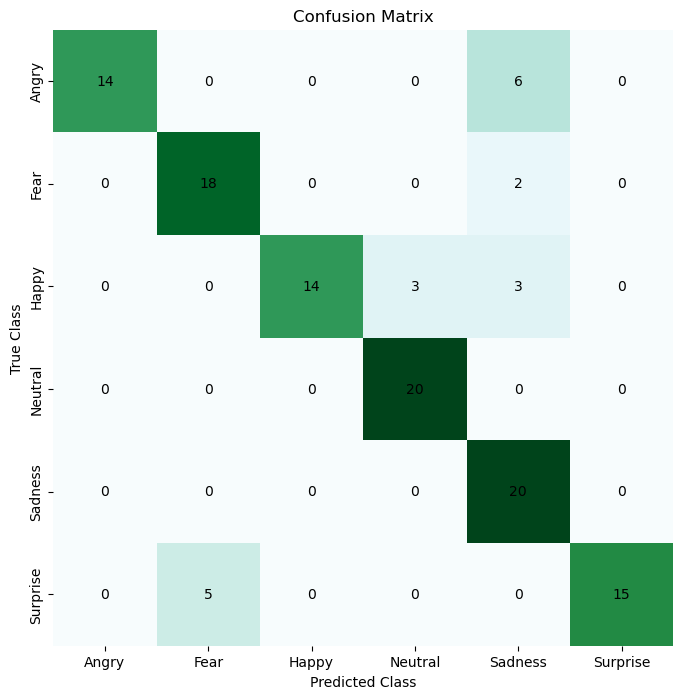

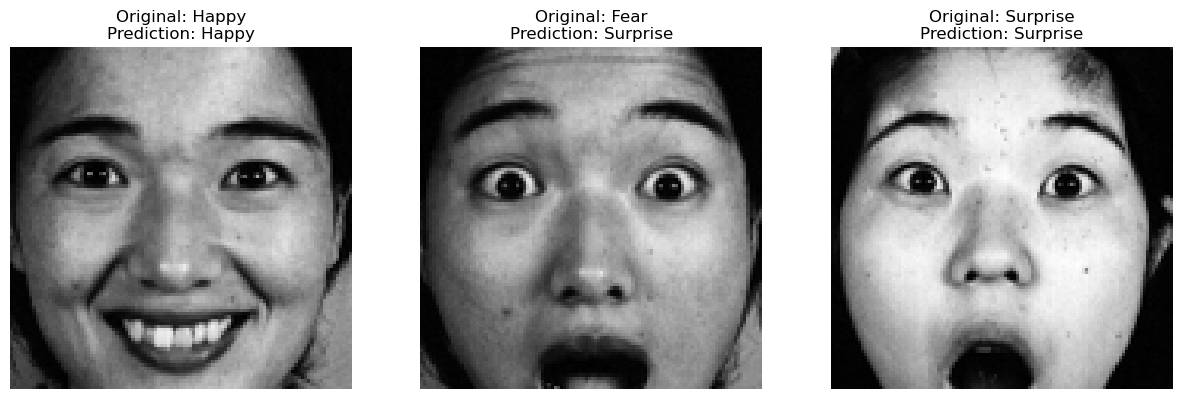

In [99]:
# Train, predict, calculate accuracy and print confusion matix
train_predict_and_calc_acc(svm_classifier, *JAFFE)


Performing cross-validation:
Cross-validation accuracy scores: [0.83276451 0.81569966 0.90102389 0.83959044 0.86643836]
Mean cross-validation accuracy: 85.11%

Test Accuracy:  50.69%
Test Precision: 52.59%
Test Recall:    50.69%
Test F1-Score:  0.49

Classification Report:
               precision    recall  f1-score   support

       anger       0.78      0.44      0.57        72
        fear       0.00      0.00      0.00        72
       happy       0.93      0.89      0.91        72
     neutral       0.29      0.76      0.42        72
     sadness       0.23      0.25      0.24        72
    surprise       0.93      0.69      0.79        72

    accuracy                           0.51       432
   macro avg       0.53      0.51      0.49       432
weighted avg       0.53      0.51      0.49       432


Confusion Matrix:
[[32  0  0 36  4  0]
 [ 0  0  0 23 49  0]
 [ 0  0 64  8  0  0]
 [ 2  0  5 55  6  4]
 [ 7  0  0 47 18  0]
 [ 0  0  0 22  0 50]]


/opt/anaconda3/envs/ArtificialIntelligence-Assignment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ArtificialIntelligence-Assignment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ArtificialIntelligence-Assignment-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

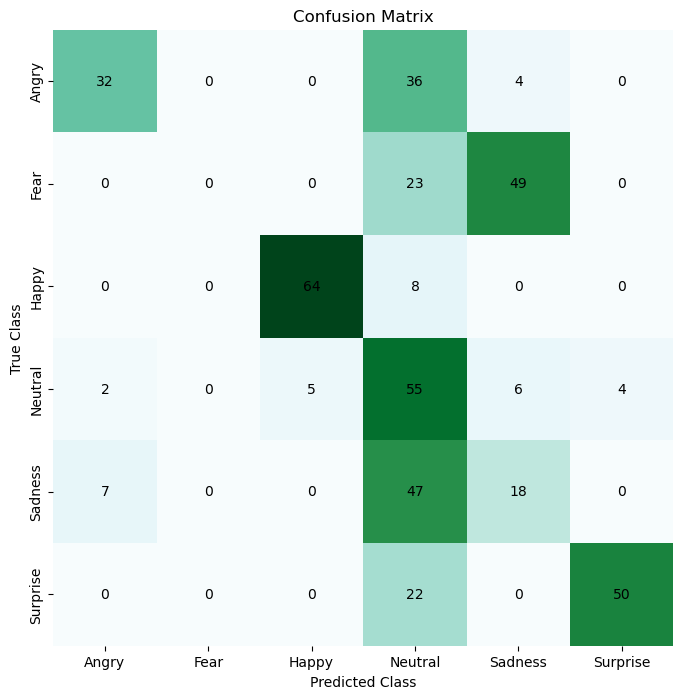

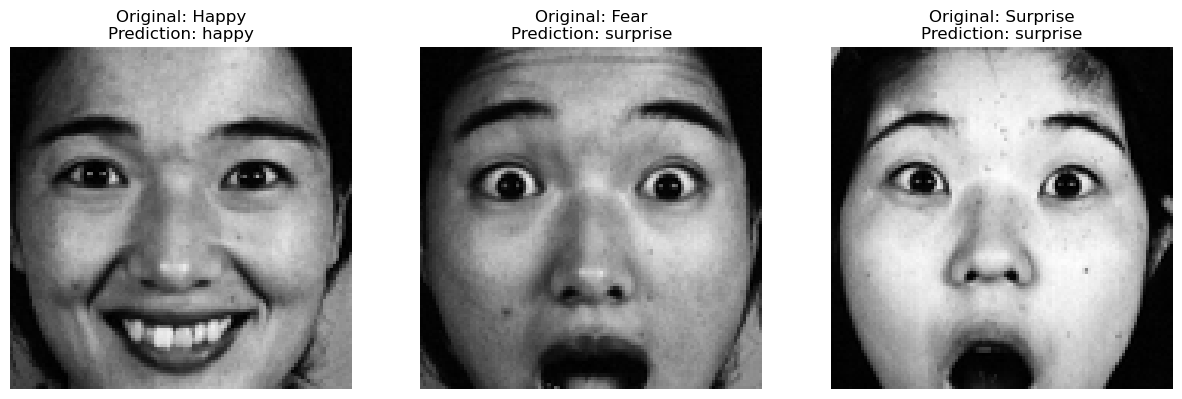

In [100]:
train_predict_and_calc_acc(svm_classifier, *CK)